# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFYtIIK69AQAc3VTErKP5CiElyT3A0A1ARKHxxtBtRyaeyvBU4auts
Mounted at /content/drive/


In [2]:
import os
os.chdir('./drive/My Drive/Code/dlcourse_ai/assignments/assignment3')

In [3]:
!ls

CNN.ipynb	   model.py		      run_record_lr_1e-2.pickle
data.json	   optim.py		      run_record_nn1.pickle
dataset.py	   PyTorch_CNN.ipynb	      run_record_nn2.pickle
download_data.sh   README.md		      test_32x32.mat
gradient_check.py  requirements.txt	      train_32x32.mat
layers.py	   run_record_lr_1e0.pickle   trainer.py
metrics.py	   run_record_lr_1e-1.pickle  Untitled0.ipynb


In [4]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-09-09 10:38:34--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-09-09 10:38:34--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pickle
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [6]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [7]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [10]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_epoch=None, 
                silent=False):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        if scheduler is not None:
          if epoch != 0 and scheduler_epoch % epoch == 0:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if not silent:
          print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    if silent:
      print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples, total_samples = 0, 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    return correct_samples.item()/total_samples

In [21]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.377189, Train accuracy: 0.543682, Val accuracy: 0.758993
Average loss: 0.707525, Train accuracy: 0.782684, Val accuracy: 0.802198
Average loss: 0.604888, Train accuracy: 0.820035, Val accuracy: 0.801720
Average loss: 0.552691, Train accuracy: 0.835085, Val accuracy: 0.843424
Average loss: 0.520937, Train accuracy: 0.844436, Val accuracy: 0.850522


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [12]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

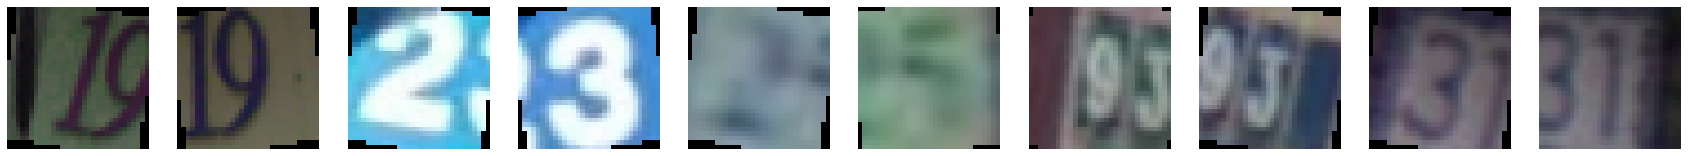

In [13]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [14]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [26]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.615388, Train accuracy: 0.814609, Val accuracy: 0.826428
Average loss: 0.561433, Train accuracy: 0.829471, Val accuracy: 0.852911
Average loss: 0.532193, Train accuracy: 0.838856, Val accuracy: 0.853457
Average loss: 0.520915, Train accuracy: 0.842781, Val accuracy: 0.840284
Average loss: 0.504299, Train accuracy: 0.846227, Val accuracy: 0.853798


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [15]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 120, 5),
            nn.Tanh(),
            Flattener(),
            nn.Linear(120, 84),        
            nn.Tanh(),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [19]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 2.133554, Train accuracy: 0.246425, Val accuracy: 0.519965
Average loss: 0.926466, Train accuracy: 0.706242, Val accuracy: 0.800218
Average loss: 0.588771, Train accuracy: 0.816435, Val accuracy: 0.818511
Average loss: 0.502518, Train accuracy: 0.843224, Val accuracy: 0.859805
Average loss: 0.451168, Train accuracy: 0.860816, Val accuracy: 0.868746
Average loss: 0.417961, Train accuracy: 0.870474, Val accuracy: 0.878643
Average loss: 0.395125, Train accuracy: 0.878238, Val accuracy: 0.882534
Average loss: 0.376146, Train accuracy: 0.884227, Val accuracy: 0.885332
Average loss: 0.361223, Train accuracy: 0.888441, Val accuracy: 0.888404
Average loss: 0.347559, Train accuracy: 0.892417, Val accuracy: 0.886288


# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg', 'optim_name', 'scheduler_name', 'anneal_epoch'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1., 2., 5.]
regs = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

lmbda = lambda epoch: anneal_coeff
# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
for lr in learning_rates:
  for reg in regs:
    for optim_name in ['SGD', 'RMSprop']:
      for scheduler_name in ['None', 'Multiplicative']:
        for anneal_epoch in anneal_epochs:
          lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 120, 5), nn.Tanh(),
            Flattener(),
            nn.Linear(120, 84), nn.Tanh(),
            nn.Linear(84, 10),
          )
          optimizers = {
              'SGD': optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg),
              'RMSprop': optim.RMSprop(lenet_model.parameters(), lr=lr, weight_decay=reg, momentum=0.9)
              }
          optimizer = optimizers[optim_name]  
          schedulers = {
              'None': None,
              'Multiplicative': optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
            }
          scheduler = schedulers[scheduler_name]
          if scheduler is None:
            anneal_epoch = None
          lenet_model.cuda()
          loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss,
                                                                 optimizer, 10, scheduler, anneal_epoch, silent=True)
          key = Hyperparams(lr, reg, optim_name, scheduler_name, anneal_epoch)
          value = RunResult(lenet_model, train_history, val_history, val_history[-1])
          run_record[key] = value
          with open('run_record_1.pickle', 'wb') as handle:
            pickle.dump(run_record, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average loss: 2.236237, Train accuracy: 0.189025, Val accuracy: 0.189953
Average loss: 2.236558, Train accuracy: 0.189025, Val accuracy: 0.189953
Average loss: 2.237109, Train accuracy: 0.189025, Val accuracy: 0.189953
Average loss: 2.251579, Train accuracy: 0.189008, Val accuracy: 0.189885
Average loss: 2.258566, Train accuracy: 0.189025, Val accuracy: 0.189953
Average loss: 2.258819, Train accuracy: 0.189008, Val accuracy: 0.190021
Average loss: 2.285975, Train accuracy: 0.169164, Val accuracy: 0.152140
Average loss: 0.811056, Train accuracy: 0.750606, Val accuracy: 0.786772
Average loss: 0.826401, Train accuracy: 0.743388, Val accuracy: 0.766569
Average loss: 0.437505, Train accuracy: 0.865031, Val accuracy: 0.875162
Average loss: 0.398309, Train accuracy: 0.879995, Val accuracy: 0.881032
Average loss: 0.348760, Train accuracy: 0.896325, Val accuracy: 0.898573
Average loss: 2.237727, Train accuracy: 0.189025, Val accuracy: 0.189953
Average loss: 2.236838, Train accuracy: 0.189025, V

In [20]:
# Colab failed to run the loop from above at once
# Saves results to disk and concat it now
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg', 'optim_name', 'scheduler_name', 'anneal_epoch'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

run_record = {}
for name in ['run_record_lr_1e0', 'run_record_lr_1e-1', 'run_record_lr_1e-2']:
  with open('%s.pickle' % name, 'rb') as f:
    if not len(run_record):
      run_record = pickle.load(f)
    else:
      run_record.update(pickle.load(f))

In [23]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))   

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.001, reg=0.001, optim_name='RMSprop', scheduler_name='Multiplicative', anneal_epoch=5.0)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [22]:
run_record = {}
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-3, 1e-4]
regs = [1e-3, 1e-4, 1e-5]

anneal_coeff, anneal_epoch = 0.2, 5
lmbda = lambda epoch: anneal_coeff

for lr in learning_rates:
  for reg in regs:
    nn_model = nn.Sequential(
      nn.Conv2d(3, 8, 5), nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(8, 32, 5), nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 140, 5), nn.ReLU(),
      Flattener(),
      nn.Linear(140, 84), nn.ReLU(),
      nn.Linear(84, 10),
    )
    optimizer = optim.RMSprop(nn_model.parameters(), lr=lr, weight_decay=reg, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    nn_model.cuda()
    loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss,
                                                            optimizer, 10, scheduler, anneal_epoch)
    key = Hyperparams(lr, reg)
    value = RunResult(nn_model, train_history, val_history, val_history[-1])
    run_record[key] = value
    with open('run_record_nn1.pickle', 'wb') as handle:
      pickle.dump(run_record, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average loss: 2.092212, Train accuracy: 0.256168, Val accuracy: 0.713467
Average loss: 0.871440, Train accuracy: 0.737484, Val accuracy: 0.769094
Average loss: 0.573244, Train accuracy: 0.830000, Val accuracy: 0.853935
Average loss: 0.495232, Train accuracy: 0.849811, Val accuracy: 0.866767
Average loss: 0.455822, Train accuracy: 0.861669, Val accuracy: 0.862876
Average loss: 0.437077, Train accuracy: 0.868034, Val accuracy: 0.881646
Average loss: 0.362837, Train accuracy: 0.888817, Val accuracy: 0.891816
Average loss: 0.344457, Train accuracy: 0.896052, Val accuracy: 0.891407
Average loss: 0.333866, Train accuracy: 0.898696, Val accuracy: 0.896389
Average loss: 0.325352, Train accuracy: 0.901921, Val accuracy: 0.898846
Average loss: 1.864888, Train accuracy: 0.352455, Val accuracy: 0.679954
Average loss: 0.888967, Train accuracy: 0.739003, Val accuracy: 0.806976
Average loss: 0.526351, Train accuracy: 0.845408, Val accuracy: 0.860897
Average loss: 0.446926, Train accuracy: 0.867215, V

In [34]:
run_record = {}
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-2, 1e-3, 1e-4]
regs = [1e-3, 1e-4, 1e-5]

anneal_coeff, anneal_epoch = 0.2, 5
lmbda = lambda epoch: anneal_coeff

for lr in learning_rates:
  for reg in regs:
    nn_model = nn.Sequential(
      nn.Conv2d(3, 8, 5), nn.ReLU(), nn.BatchNorm2d(8),
      nn.AvgPool2d(2),
      nn.Conv2d(8, 16, 5), nn.ReLU(), nn.BatchNorm2d(16),
      nn.AvgPool2d(2),
      nn.Conv2d(16, 64, 5), nn.ReLU(), nn.BatchNorm2d(64),
      Flattener(),
      nn.Linear(64, 84), nn.ReLU(),
      nn.Linear(84, 10)
      )
    optimizer = optim.RMSprop(nn_model.parameters(), lr=lr, weight_decay=reg, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    nn_model.cuda()
    loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss,
                                                            optimizer, 10, scheduler, anneal_epoch)
    key = Hyperparams(lr, reg)
    value = RunResult(nn_model, train_history, val_history, val_history[-1])
    run_record[key] = value
    with open('run_record_nn2.pickle', 'wb') as handle:
      pickle.dump(run_record, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average loss: 2.312721, Train accuracy: 0.181432, Val accuracy: 0.138762
Average loss: 2.268779, Train accuracy: 0.182558, Val accuracy: 0.188793
Average loss: 1.512509, Train accuracy: 0.473467, Val accuracy: 0.732783
Average loss: 0.740361, Train accuracy: 0.765894, Val accuracy: 0.781380
Average loss: 0.706094, Train accuracy: 0.779511, Val accuracy: 0.780834
Average loss: 0.701733, Train accuracy: 0.780859, Val accuracy: 0.773667
Average loss: 0.535237, Train accuracy: 0.834778, Val accuracy: 0.860556
Average loss: 0.515560, Train accuracy: 0.839641, Val accuracy: 0.852979
Average loss: 0.510839, Train accuracy: 0.841757, Val accuracy: 0.859805
Average loss: 0.509642, Train accuracy: 0.842473, Val accuracy: 0.860556
Average loss: 2.301782, Train accuracy: 0.181312, Val accuracy: 0.184493
Average loss: 2.283707, Train accuracy: 0.180135, Val accuracy: 0.150297
Average loss: 1.609521, Train accuracy: 0.434734, Val accuracy: 0.793802
Average loss: 0.633553, Train accuracy: 0.802989, V

In [19]:
# Colab failed to run the loop from above at once
# Saves results to disk and concat it now
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

run_record = {}
with open('run_record_nn1.pickle', 'rb') as f:
  run_record1 = pickle.load(f)
with open('run_record_nn2.pickle', 'rb') as f:
  run_record2 = pickle.load(f)


def find_best(run_record, name):
  best_val_accuracy = None
  best_hyperparams = None
  best_run = None

  for hyperparams, run_result in run_record.items():
      if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
          best_val_accuracy = run_result.final_val_accuracy
          best_hyperparams = hyperparams
          best_run = run_result       
  print("%s, Best validation accuracy: %4.3f, best hyperparams: %s" % (name, best_val_accuracy, best_hyperparams))

find_best(run_record1, 'nn1')
find_best(run_record2, 'nn2')

nn1, Best validation accuracy: 0.909, best hyperparams: Hyperparams(learning_rate=0.0001, reg=0.0001)
nn2, Best validation accuracy: 0.910, best hyperparams: Hyperparams(learning_rate=0.001, reg=0.0001)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [33]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
# best_model = run_record2[Hyperparams(learning_rate=0.001, reg=0.0001)][0]
best_model = run_record1[Hyperparams(learning_rate=0.0001, reg=0.0001)][0]

best_model.eval()
correct_samples, total_samples = 0, 0
for i_step, (x, y) in enumerate(test_loader):
  x_gpu = x.to(device)
  y_gpu = y.to(device)
  prediction = best_model(x_gpu)    

  _, indices = torch.max(prediction, 1)
  correct_samples += torch.sum(indices == y_gpu)
  total_samples += y.shape[0]

test_accuracy = float(correct_samples) / total_samples
print("Final test accuracy - %4.2f%%" % (test_accuracy*100))

Final test accuracy - 90.25%
